In [7]:
conda install -c conda-forge xgboost

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  conda-forge
    conda-4.10.3               |   py38h50d1736_0         3.1 MB  conda-forge
    libxgboost-1.3.3           |       h23ab428_0         1.2 MB
    py-xgboost-1.3.3           |   py38hecd8cb5_0         136 KB
    python_abi-3.8             |           2_cp38           4 KB  conda-forge
    xgboost-1.3.3              |   py38hecd8cb5_0          23 KB
    ------------------------------------------------------------
                                           Total:  

In [2]:
import xgboost as xgb

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score

In [4]:
test_data=pd.read_csv('/Users/jinglinhui/Desktop/Data_analytics_project/log_regression/test.csv')
train_data=pd.read_csv('/Users/jinglinhui/Desktop/Data_analytics_project/log_regression/train.csv')

In [5]:
train_data['Age'] = train_data.groupby(['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.mean()))
train_data["Embarked"].fillna(train_data['Embarked'].value_counts().idxmax(), inplace=True)

In [6]:
train_data.drop("Cabin", inplace=True, axis=1)
train_data.drop(['PassengerId'], axis=1,inplace=True)
train_data.drop("Name", inplace=True, axis=1)
train_data.drop("Ticket", inplace=True, axis=1)


In [7]:
train_data["Sex"] = train_data["Sex"].map({'male':1, 'female':0})
embarked =pd.get_dummies(train_data['Embarked'],drop_first=True)
train_data = pd.concat([train_data, embarked], axis=1)
train_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Q,S
0,0,3,1,22.00,1,0,7.2500,S,0,1
1,1,1,0,38.00,1,0,71.2833,C,0,0
2,1,3,0,26.00,0,0,7.9250,S,0,1
3,1,1,0,35.00,1,0,53.1000,S,0,1
4,0,3,1,35.00,0,0,8.0500,S,0,1
...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.00,0,0,13.0000,S,0,1
887,1,1,0,19.00,0,0,30.0000,S,0,1
888,0,3,0,21.75,1,2,23.4500,S,0,1
889,1,1,1,26.00,0,0,30.0000,C,0,0


In [8]:
train_data.drop("Embarked", inplace=True, axis=1)

In [9]:
train_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Q           0
S           0
dtype: int64

In [10]:
test_data['Age'] = test_data.groupby(['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.mean()))
test_data["Embarked"].fillna(test_data['Embarked'].value_counts().idxmax(), inplace=True)
test_data["Sex"] = test_data["Sex"].map({'male':1, 'female':0})
embarked_test = pd.get_dummies(test_data["Embarked"], drop_first=True)
test_data = pd.concat([test_data, embarked_test], axis=1)
test_data["Fare"].fillna(test_data["Fare"].mean(skipna=True), inplace=True)

In [11]:
test_data = test_data.drop(['PassengerId'], axis=1)
test_data.drop('Cabin', axis=1, inplace=True)
test_data.drop("Name", inplace=True, axis=1)
test_data.drop("Ticket", inplace=True, axis=1)
test_data.drop("Embarked", inplace=True, axis=1)

In [12]:
test_data.isnull().sum()

Pclass    0
Sex       0
Age       0
SibSp     0
Parch     0
Fare      0
Q         0
S         0
dtype: int64

In [13]:
X_train = train_data.drop("Survived", axis=1)
Y_train = train_data["Survived"]

In [54]:
data_dmatrix = xgb.DMatrix(data=X_train,label=Y_train)

In [98]:
param_grid = {'eta': [0.1,0.2, 0.3,0.4],#'objective':'binary:logistic'
              'gamma': [0,0.1,0.2],
              'max_depth': [2, 3, 5, 10],
              'colsample_bytree': [0.5,0.7,0.9,1],
             }

In [99]:
import itertools as it
parameters = it.product(*(param_grid[title] for title in list(param_grid)))
print(list(param_grid))

['eta', 'gamma', 'max_depth', 'colsample_bytree']


In [100]:
def cross_validation_split(dataset, folds):
        dataset_split = []
        fold_size = int(X_train.shape[0] / folds) #number of rows in each fold
        ini_index=[0] #start from index 0
        remains= fold_size % folds 
        
        
        # for loop to save each fold
        for i in range(1,remains):
            ini_index.append(i*fold_size+1)

        for j in range (remains, folds+1):
            ini_index.append(j*fold_size+remains)

            # save the fold     
        for n in range(len(ini_index)-1):
            dataset_split.append([ini_index[n], ini_index[n+1]])
            
        return dataset_split 

In [101]:
index=cross_validation_split(X_train,5)
index

[[0, 179], [179, 357], [357, 537], [537, 715], [715, 893]]

In [102]:
def xg_boost(X_train, Y_train,params,num_boosting_round,early_stopping_round, k):
    index=cross_validation_split(X_train,k)
    
    auc = []
    br = []
    score=[]
    for i in range(k):
        
        cv_xtest = X_train.iloc[index[i][0]:index[i][1],:]
        cv_ytest = Y_train.iloc[index[i][0]:index[i][1],]
    
        cv_xtrain = X_train.drop(X_train.index[index[i][0]:index[i][1]])
        cv_ytrain = Y_train.drop(X_train.index[index[i][0]:index[i][1]])
        
        d_train = xgb.DMatrix(data = cv_xtrain, label = cv_ytrain)
        d_test = xgb.DMatrix(data = cv_xtest, label = cv_ytest)
        xgb_train = xgb.train(params = params,dtrain = d_train,num_boost_round = num_boosting_round,
                              early_stopping_rounds = early_stopping_round,
                              evals=[(d_train,'train'),(d_test, 'test')])#,eval_metric='auc')
        
        #use auc to evaluate 
        fpr, tpr, threshold = roc_curve(cv_ytest, xgb_train.predict(d_test))
        auc_roc = metrics.auc(fpr, tpr)
        auc.append(auc_roc)
        best_round = xgb_train.best_iteration
        value = xgb_train.best_score
        score.append(value)
        br.append(best_round)
    
    return np.mean(auc),best_round,value                   


In [103]:
for i in list(parameters):
    param_opt = {'eta': i[0], #'objective':i[0]
                 'gamma': i[1],
                 'max_depth': i[2],
                 'colsample_bytree': i[3]}
best_round = xg_boost(X_train, Y_train,param_opt, 2000, 50,5)

        

print(best_round,i)

[0]	train-rmse:0.36286	test-rmse:0.42798
[1]	train-rmse:0.28506	test-rmse:0.39779
[2]	train-rmse:0.24564	test-rmse:0.38664
[3]	train-rmse:0.22467	test-rmse:0.38739
[4]	train-rmse:0.21676	test-rmse:0.38618
[5]	train-rmse:0.21341	test-rmse:0.38546
[6]	train-rmse:0.20725	test-rmse:0.38372
[7]	train-rmse:0.20724	test-rmse:0.38357
[8]	train-rmse:0.20724	test-rmse:0.38348
[9]	train-rmse:0.20723	test-rmse:0.38343
[10]	train-rmse:0.20723	test-rmse:0.38340
[11]	train-rmse:0.20723	test-rmse:0.38338
[12]	train-rmse:0.20723	test-rmse:0.38337
[13]	train-rmse:0.20723	test-rmse:0.38336
[14]	train-rmse:0.20723	test-rmse:0.38336
[15]	train-rmse:0.20723	test-rmse:0.38336
[16]	train-rmse:0.20723	test-rmse:0.38336
[17]	train-rmse:0.20723	test-rmse:0.38335
[18]	train-rmse:0.20723	test-rmse:0.38335
[19]	train-rmse:0.20723	test-rmse:0.38335
[20]	train-rmse:0.20723	test-rmse:0.38335
[21]	train-rmse:0.20723	test-rmse:0.38335
[22]	train-rmse:0.20723	test-rmse:0.38335
[23]	train-rmse:0.20723	test-rmse:0.38335
[2

[20]	train-rmse:0.18575	test-rmse:0.39719
[21]	train-rmse:0.18575	test-rmse:0.39719
[22]	train-rmse:0.18575	test-rmse:0.39719
[23]	train-rmse:0.18575	test-rmse:0.39719
[24]	train-rmse:0.18575	test-rmse:0.39719
[25]	train-rmse:0.18575	test-rmse:0.39719
[26]	train-rmse:0.18575	test-rmse:0.39719
[27]	train-rmse:0.18575	test-rmse:0.39719
[28]	train-rmse:0.18575	test-rmse:0.39719
[29]	train-rmse:0.18575	test-rmse:0.39719
[30]	train-rmse:0.18575	test-rmse:0.39719
[31]	train-rmse:0.18575	test-rmse:0.39719
[32]	train-rmse:0.18575	test-rmse:0.39719
[33]	train-rmse:0.18575	test-rmse:0.39719
[34]	train-rmse:0.18575	test-rmse:0.39719
[35]	train-rmse:0.18575	test-rmse:0.39719
[36]	train-rmse:0.18575	test-rmse:0.39719
[37]	train-rmse:0.18575	test-rmse:0.39719
[38]	train-rmse:0.18575	test-rmse:0.39719
[39]	train-rmse:0.18575	test-rmse:0.39719
[40]	train-rmse:0.18575	test-rmse:0.39719
[41]	train-rmse:0.18575	test-rmse:0.39719
[42]	train-rmse:0.18575	test-rmse:0.39719
[43]	train-rmse:0.18575	test-rmse:

In [104]:
best_param = {'eta': 0.4,'gamma': 0.2,
                'max_depth': 10, 'colsample_bytree': 1}

In [105]:
xg_reg = xgb.train(params=best_param, dtrain=data_dmatrix, num_boost_round=19)

In [110]:
pred=xg_reg.predict(data_dmatrix)
test_matrix= xgb.DMatrix(test_data)
ypreds_proba = xg_reg.predict(test_matrix)

No handles with labels found to put in legend.


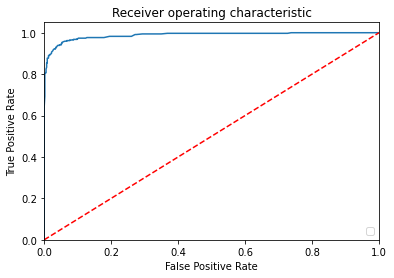

In [113]:
[fpr, tpr, thr]= roc_curve(Y_train,pred)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [117]:
print("AUC: %2.3f" % auc(fpr, tpr))

AUC: 0.988


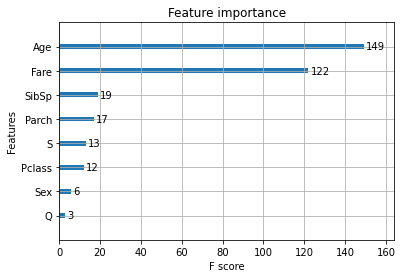

In [114]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [ ]:
[fpr, tpr, thr]= roc_curve(Y_train,ypreds_proba[:, 1])
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [119]:
train_proba = pd.DataFrame({'survival_probability' : pred})
train_proba

,survival_probability
0,0.067083
1,0.965346
2,0.599063
3,0.965346
4,0.111607
...,...
886,0.069371
887,0.975136
888,0.139844
889,0.787614


In [122]:
for i in np.arange(0, 1,0.1):
    train_survive=
    cm = confusion_matrix(Y_train,pred)
    #Accuracy (all correct / all) = TP + TN /all
    accuracy = (cm[0][0]+cm[1][1])/891
    
print(i.accuracy.max())

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [121]:
test_table = pd.DataFrame({'test_survive_probability' : ypreds_proba})
test_table

,test_survive_probability
0,0.011444
1,0.106068
2,0.306417
3,0.240159
4,0.418371
...,...
413,0.054802
414,0.965346
415,0.028927
416,0.054802
